In [ ]:
import os
import json
import random
from PIL import Image

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms

from transformers import (
    T5ForConditionalGeneration,
    T5Config,
    PreTrainedTokenizerFast,
    ViTModel,
    ViTConfig,
    get_linear_schedule_with_warmup
)
from transformers.modeling_outputs import BaseModelOutput

from tokenizers import Tokenizer
from tokenizers import models as tokenizers_models, pre_tokenizers

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from typing import Tuple, Union, Optional, List


In [ ]:
# --- Tokenizer ---
os.environ.setdefault("TOKENIZERS_PARALLELISM", "false")
def build_custom_tokenizer(vocab_path: str, max_len: int = 32) -> PreTrainedTokenizerFast:
    with open(vocab_path, 'r', encoding='utf-8') as f:
        idx2token = json.load(f)
    token2idx = {tok: int(idx) for idx, tok in idx2token.items()}
    wordlevel = tokenizers_models.WordLevel(vocab=token2idx, unk_token="<unk>")
    tok = Tokenizer(wordlevel)
    tok.pre_tokenizer = pre_tokenizers.Whitespace()
    tokenizer = PreTrainedTokenizerFast(
        tokenizer_object=tok,
        bos_token="<s>",
        eos_token="</s>",
        unk_token="<unk>",
        pad_token="<pad>"
    )
    tokenizer.model_max_length = max_len
    return tokenizer

# ---------- Dataset ----------
class ImageCaptionDataset(Dataset):
    def __init__(self, image_dir: str, captions_file: str, tokenizer, transform):
        self.image_dir = image_dir
        self.tokenizer = tokenizer
        self.transform = transform
        with open(captions_file, 'r', encoding='utf-8') as f:
            self.pairs = [l.strip().split('\t') for l in f if l.strip()]
    def __len__(self):
        return len(self.pairs)
    def __getitem__(self, idx):
        img_name, caption = self.pairs[idx]
        img = Image.open(os.path.join(self.image_dir, img_name)).convert('RGB')
        img = self.transform(img)
        enc = self.tokenizer(
            caption,
            padding='max_length',
            truncation=True,
            max_length=self.tokenizer.model_max_length,
            return_tensors='pt'
        )
        return img, enc.input_ids.squeeze(0), enc.attention_mask.squeeze(0), caption

# ---------- ViT Encoder ----------
class ViTEncoder(nn.Module):
    def __init__(self, embed_dim: int, pretrained: bool = True):
        super().__init__()
        if pretrained:
            self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        else:
            cfg = ViTConfig(
                hidden_size=embed_dim,
                num_hidden_layers=12,
                num_attention_heads=12,
                patch_size=16,
                image_size=224,
            )
            self.vit = ViTModel(cfg)
        # Freeze all except last transformer block for light fine-tuning
        for name, param in self.vit.named_parameters():
            if 'encoder.layer.11' not in name:
                param.requires_grad = False
        # Project ViT hidden to embed_dim if needed
        self.proj = nn.Linear(self.vit.config.hidden_size, embed_dim)
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        # x: (B,3,224,224)
        outputs = self.vit(pixel_values=x)
        cls_token = outputs.last_hidden_state[:, 0]       # (B, hidden)
        proj = self.proj(cls_token)                       # (B, embed_dim)
        return self.norm(proj)                            # (B, embed_dim)

# ---------- Caption Model (ViT + T5) ----------
class CaptionModel(nn.Module):
    def __init__(
        self,
        mode: str,
        tokenizer,
        pretrained_model_name: str = None,
        custom_config: T5Config = None
    ):
        super().__init__()
        embed_dim = custom_config.d_model if custom_config else 768

        # ViT encoder
        self.encoder = ViTEncoder(embed_dim, pretrained=True)
        # projection lên d_model của T5
        self.proj = nn.Linear(embed_dim, embed_dim)

        # Decoder: scratch hoặc finetune
        if mode == 'scratch':
            assert custom_config is not None
            self.decoder = T5ForConditionalGeneration(config=custom_config)
        else:
            self.decoder = T5ForConditionalGeneration.from_pretrained(pretrained_model_name)
            self.decoder.resize_token_embeddings(len(tokenizer.get_vocab()))

        self.tokenizer = tokenizer

        # Transform cho infer (có normalize)
        self.infer_transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485,0.456,0.406],
                                 std=[0.229,0.224,0.225])
        ])

    def forward(self, images, input_ids, attention_mask, labels=None):
        feats = self.encoder(images)                # (B, embed_dim)
        enc_proj = self.proj(feats).unsqueeze(1)    # (B,1,embed_dim)
        return self.decoder(
            encoder_outputs=(enc_proj,),
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels,
            return_dict=True
        )

    def generate_caption(self, image_input, max_length=32, num_beams=5):
        device = next(self.encoder.parameters()).device
        self.encoder.eval()
        self.decoder.eval()

        # Load image (path, tensor hoặc PIL)
        if isinstance(image_input, str):
            img = Image.open(image_input).convert('RGB')
        elif isinstance(image_input, torch.Tensor):
            img = transforms.ToPILImage()(image_input.squeeze(0).cpu())
        else:
            img = image_input.convert('RGB')

        x = self.infer_transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            feats = self.encoder(x)
            enc_out = self.proj(feats).unsqueeze(1)
            encoder_outputs = BaseModelOutput(last_hidden_state=enc_out)

            start = self.decoder.config.decoder_start_token_id
            decoder_input_ids = torch.tensor([[start]], device=device)

            output_ids = self.decoder.generate(
                decoder_input_ids=decoder_input_ids,
                encoder_outputs=encoder_outputs,
                max_length=max_length,
                eos_token_id=self.tokenizer.eos_token_id,
                pad_token_id=self.tokenizer.pad_token_id,
                num_beams=num_beams,
                early_stopping=True
            )
        return self.tokenizer.decode(output_ids[0], skip_special_tokens=True).strip()

    def generate_captions_for_folder(
        self,
        folder_path: str,
        output_dir: str = ".",
        output_name: str = None,
        max_length: int = 32,
        num_beams: int = 5
    ):
        os.makedirs(output_dir, exist_ok=True)
        foldername = os.path.basename(folder_path.rstrip(os.sep))
        if output_name:
            base, ext = os.path.splitext(output_name)
            ext = ext or ".txt"
            filename = base + ext
        else:
            filename = f"cap_{foldername}.txt"
        out_path = os.path.join(output_dir, filename)

        files = sorted(
            f for f in os.listdir(folder_path)
            if f.lower().endswith(("jpg","jpeg","png"))
        )
        with open(out_path, "w", encoding="utf-8") as fw:
            for fname in files:
                img_path = os.path.join(folder_path, fname)
                cap = self.generate_caption(img_path, max_length, num_beams)
                fw.write(f"{fname}\t{cap}\n")
        print(f"Saved captions to {out_path}")
        return out_path

# ---------- Training & Validation ----------
def train_and_validate(
    model,
    train_dl,
    val_dl,
    device,
    mode: str = "finetune",
    output_dir: str = ".",
    epochs: int = 5,
    lr: float = 1e-4,
    patience: int = 3
):
    os.makedirs(output_dir, exist_ok=True)
    optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    total_steps = epochs * len(train_dl)
    warmup = int(0.1 * total_steps)
    scheduler = get_linear_schedule_with_warmup(optimizer, warmup, total_steps)

    best_loss = float('inf')
    no_improve = 0
    ckpt_path = os.path.join(output_dir, f"best_{mode}_checkpoint.pt")

    model.to(device)
    for ep in range(1, epochs+1):
        model.train()
        for imgs, ids, masks, _ in tqdm(train_dl, desc=f"Train Epoch {ep}/{epochs}"):
            imgs, ids, masks = imgs.to(device), ids.to(device), masks.to(device)
            loss = model(imgs, ids, masks, labels=ids).loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

        if val_dl:
            model.eval()
            val_loss = 0
            cnt = 0
            with torch.no_grad():
                for imgs, ids, masks, _ in val_dl:
                    imgs, ids, masks = imgs.to(device), ids.to(device), masks.to(device)
                    val_loss += model(imgs, ids, masks, labels=ids).loss.item()
                    cnt += 1
            avg_val = val_loss / cnt
            print(f"Epoch {ep} Validation Loss: {avg_val:.4f}")
        else:
            avg_val = float('inf')

        if avg_val < best_loss:
            best_loss = avg_val
            torch.save(model.state_dict(), ckpt_path)
            print(f"-- Saved best checkpoint at {ckpt_path} (loss: {best_loss:.4f}) --")
            no_improve = 0
        else:
            no_improve += 1
            print(f"-- No improvement for {no_improve} epoch(s) --")
            if no_improve >= patience:
                print(f"Early stopping after {patience} epochs.")
                break

    # Load best
    model.load_state_dict(torch.load(ckpt_path))
    return model

# ---------- Utility: Hiển thị kết quả ----------
def show_first_test_images_and_caption(model, test_images_dir: str, n: int = 10, max_length: int = 32):
    files = sorted([f for f in os.listdir(test_images_dir) if f.lower().endswith(('jpg','jpeg','png'))])
    for fname in files[:n]:
        path = os.path.join(test_images_dir, fname)
        img = Image.open(path).convert('RGB')
        cap = model.generate_caption(path, max_length=max_length)
        plt.figure(figsize=(4,4))
        plt.imshow(img)
        plt.axis('off')
        plt.title(cap)
        plt.show()

def _strip_module_prefix(sd: dict) -> dict:
    """Bỏ tiền tố 'module.' nếu checkpoint lưu từ DataParallel."""
    if any(k.startswith('module.') for k in sd.keys()):
        return {k[len('module.'):]: v for k, v in sd.items()}
    return sd

@torch.no_grad()
def load_checkpoint(
    ckpt_path: str,
    vocab_path: str,
    *,
    d_model: int = 768,
    d_ff: int = 3072,
    num_layers: int = 12,
    num_heads: int = 12,
    device: Optional[str] = None,
) -> Tuple["CaptionModel", PreTrainedTokenizerFast]:
    """
    Dựng tokenizer + mô hình T5-scratch (khớp cấu hình lúc train) và nạp state_dict từ ckpt_path.
    """
    assert os.path.isfile(ckpt_path), f"Checkpoint not found: {ckpt_path}"
    assert os.path.isfile(vocab_path), f"Vocab not found: {vocab_path}"

    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer = build_custom_tokenizer(vocab_path=vocab_path, max_len=32)

    cfg = T5Config(
        vocab_size=len(tokenizer.get_vocab()),
        d_model=d_model,
        d_ff=d_ff,
        num_layers=num_layers,
        num_heads=num_heads,
        decoder_start_token_id=tokenizer.bos_token_id,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,
    )
    model = CaptionModel(mode='scratch', tokenizer=tokenizer, custom_config=cfg).to(device)
    model.eval()

    # Tải state_dict
    sd = torch.load(ckpt_path, map_location=device)
    if isinstance(sd, dict) and "state_dict" in sd:
        sd = sd["state_dict"]
    sd = _strip_module_prefix(sd)

    missing, unexpected = model.load_state_dict(sd, strict=False)
    if missing:
        print(f"[load_checkpoint] Missing keys: {missing}")
    if unexpected:
        print(f"[load_checkpoint] Unexpected keys: {unexpected}")

    return model, tokenizer

# ---------- Pipeline ----------
def run_pipeline(
    mode,
    vocab_path,
    train_imgs,
    train_caps,
    val_imgs=None,
    val_caps=None,
    test_imgs=None,
    model_name='t5-base',
    epochs=5,
    batch_size=8,
    lr=1e-4,
    device=None
):
    device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
    tokenizer = build_custom_tokenizer(vocab_path)

    # Khởi tạo model
    if mode == 'scratch':
        cfg = T5Config(
            vocab_size=len(tokenizer.get_vocab()),
            d_model=768, d_ff=3072,
            num_layers=12, num_heads=12,
            decoder_start_token_id=tokenizer.bos_token_id,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id
        )
        model = CaptionModel('scratch', tokenizer, custom_config=cfg)
    else:
        model = CaptionModel('finetune', tokenizer, pretrained_model_name=model_name)

    # Transforms (có normalize)
    trans = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],
                             std=[0.229,0.224,0.225])
    ])

    train_dl = DataLoader(
        ImageCaptionDataset(train_imgs, train_caps, tokenizer, trans),
        batch_size=batch_size, shuffle=True, num_workers=4
    )
    val_dl = None
    if val_imgs and val_caps:
        val_dl = DataLoader(
            ImageCaptionDataset(val_imgs, val_caps, tokenizer, trans),
            batch_size=1, shuffle=False, num_workers=4
        )

    model = train_and_validate(
        model, train_dl, val_dl, device,
        mode=mode, output_dir='.', epochs=epochs, lr=lr, patience=3
    )

    if test_imgs:
        print("-- Test Random Samples --")
        show_first_test_images_and_caption(
            model, test_imgs, n=5,
            max_length=tokenizer.model_max_length
        )
    return model

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Train Epoch 1/100:   0%|          | 0/393 [00:00<?, ?it/s]

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch 1 Validation Loss: 2.4859
-- Saved best checkpoint at ./best_scratch_checkpoint.pt (loss: 2.4859) --


Train Epoch 2/100:   0%|          | 0/393 [00:00<?, ?it/s]

Epoch 2 Validation Loss: 2.2385
-- Saved best checkpoint at ./best_scratch_checkpoint.pt (loss: 2.2385) --


Train Epoch 3/100:   0%|          | 0/393 [00:00<?, ?it/s]

Epoch 3 Validation Loss: 1.9534
-- Saved best checkpoint at ./best_scratch_checkpoint.pt (loss: 1.9534) --


Train Epoch 4/100:   0%|          | 0/393 [00:00<?, ?it/s]

Epoch 4 Validation Loss: 1.7458
-- Saved best checkpoint at ./best_scratch_checkpoint.pt (loss: 1.7458) --


Train Epoch 5/100:   0%|          | 0/393 [00:00<?, ?it/s]

Epoch 5 Validation Loss: 1.6261
-- Saved best checkpoint at ./best_scratch_checkpoint.pt (loss: 1.6261) --


Train Epoch 6/100:   0%|          | 0/393 [00:00<?, ?it/s]

Epoch 6 Validation Loss: 1.5659
-- Saved best checkpoint at ./best_scratch_checkpoint.pt (loss: 1.5659) --


Train Epoch 7/100:   0%|          | 0/393 [00:00<?, ?it/s]

Epoch 7 Validation Loss: 1.5314
-- Saved best checkpoint at ./best_scratch_checkpoint.pt (loss: 1.5314) --


Train Epoch 8/100:   0%|          | 0/393 [00:00<?, ?it/s]

Epoch 8 Validation Loss: 1.4978
-- Saved best checkpoint at ./best_scratch_checkpoint.pt (loss: 1.4978) --


Train Epoch 9/100:   0%|          | 0/393 [00:00<?, ?it/s]

Epoch 9 Validation Loss: 1.4834
-- Saved best checkpoint at ./best_scratch_checkpoint.pt (loss: 1.4834) --


Train Epoch 10/100:   0%|          | 0/393 [00:00<?, ?it/s]

Epoch 10 Validation Loss: 1.4863
-- No improvement for 1 epoch(s) --


Train Epoch 11/100:   0%|          | 0/393 [00:00<?, ?it/s]

Epoch 11 Validation Loss: 1.4781
-- Saved best checkpoint at ./best_scratch_checkpoint.pt (loss: 1.4781) --


Train Epoch 12/100:   0%|          | 0/393 [00:00<?, ?it/s]

Epoch 12 Validation Loss: 1.4754
-- Saved best checkpoint at ./best_scratch_checkpoint.pt (loss: 1.4754) --


Train Epoch 13/100:   0%|          | 0/393 [00:00<?, ?it/s]

Epoch 13 Validation Loss: 1.4826
-- No improvement for 1 epoch(s) --


Train Epoch 14/100:   0%|          | 0/393 [00:00<?, ?it/s]

Epoch 14 Validation Loss: 1.4980
-- No improvement for 2 epoch(s) --


Train Epoch 15/100:   0%|          | 0/393 [00:00<?, ?it/s]

Epoch 15 Validation Loss: 1.5186
-- No improvement for 3 epoch(s) --
Early stopping after 3 epochs.
-- Test Random Samples --


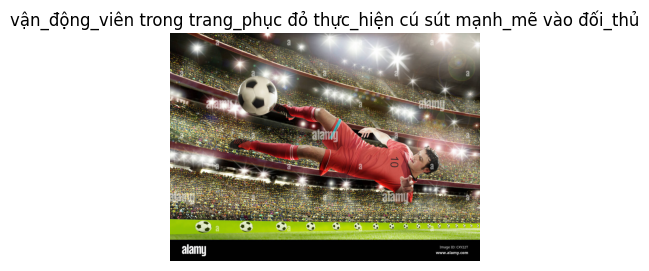

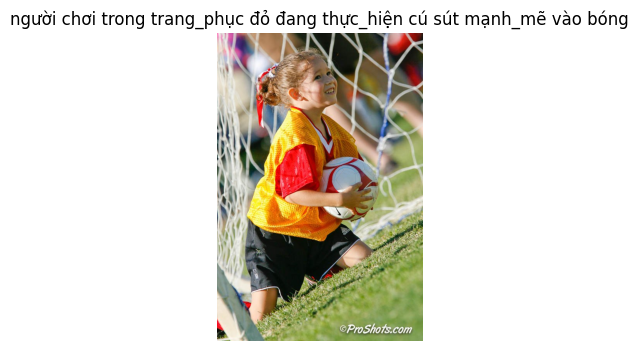

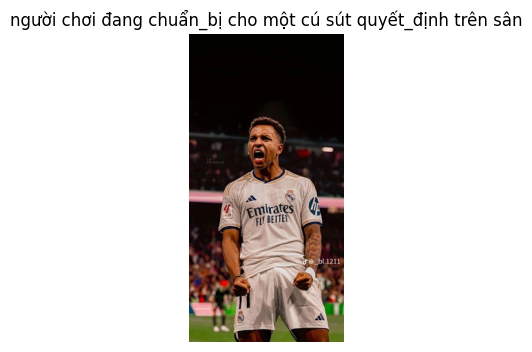

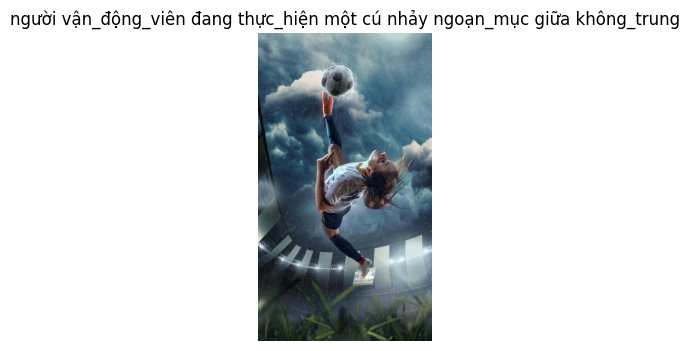

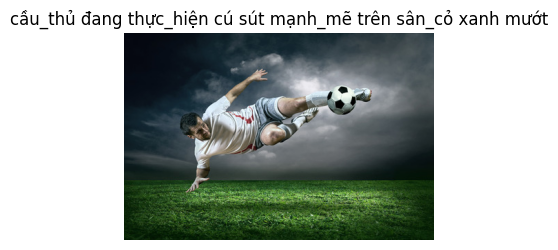

Saved captions to /kaggle/working/scratch_cap_1.txt


In [3]:
# Chạy pipeline
if __name__ == "__main__":
    vocab_path = '/kaggle/input/caption-dataset/ic_dataset/vocab/idx_to_word.json'
    train_imgs  = '/kaggle/input/caption-dataset/ic_dataset/train/images'
    train_caps  = '/kaggle/input/caption-dataset/ic_dataset/train/captions.txt'
    val_imgs    = '/kaggle/input/caption-dataset/ic_dataset/val/images'
    val_caps    = '/kaggle/input/caption-dataset/ic_dataset/val/captions.txt'
    test_imgs   = '/kaggle/input/caption-dataset/ic_dataset/test/images'

    retrained_model = run_pipeline(
        mode='scratch',
        vocab_path=vocab_path,
        train_imgs=train_imgs,
        train_caps=train_caps,
        val_imgs=val_imgs,
        val_caps=val_caps,
        test_imgs=test_imgs,
        model_name='t5-base',
        epochs=100,
        batch_size=16,
        lr=5e-5
    )

    # Sinh captions cho thư mục test
    retrained_model.generate_captions_for_folder(
        '/kaggle/input/caption-dataset/ic_dataset/test/images',
        output_dir="/kaggle/working/",
        output_name="scratch_cap_1.txt",
        max_length=30,
        num_beams=5
    )